In [5]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt


In [6]:
traj = md.load('../../xtc_files/50000eql2.xtc', top='../../xtc_files/conf.gro')


In [7]:
# converting traj as traj with only 5000 frames
traj=traj[::3]

In [8]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in range(nframes):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

(16667, 592, 3)


In [9]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in range(nframes):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

16667


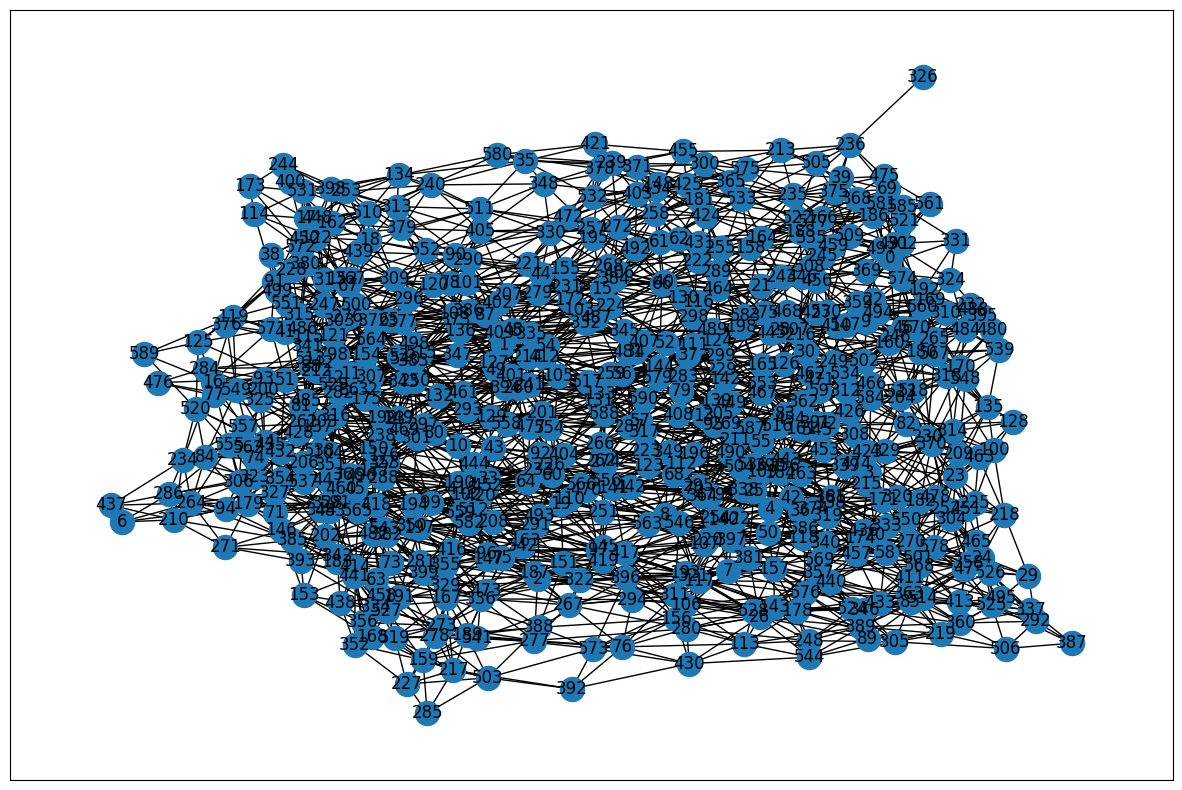

In [10]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [11]:
graphs = []
for frame in range(nframes):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

Data(x=[592, 3], edge_index=[2, 8126], y=[1])


In [12]:
# import model.
from model import *

In [13]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
from pytorch3d.loss import chamfer_distance

In [15]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [16]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [17]:
total_train_losses = []
feature_train_losses = []
edge_train_losses = []
kl_train_losses = []
closs_train_losses=[]

# validation will be done after training
# training done now
for epoch in range(1,epochs+1):
    tloss,cdloss,floss,eloss,klloss = train()
    print(f'Epoch: {epoch:03d}')
    print(f'Train Loss: {tloss:.4f}, Chamfer Loss: {cdloss:.4f}, Feature Loss: {floss:.4f}, Edge Loss: {eloss:.4f}, KL Loss: {klloss:.4f}')
    total_train_losses.append(tloss)
    feature_train_losses.append(floss)
    edge_train_losses.append(eloss)
    kl_train_losses.append(klloss)
    closs_train_losses.append(cdloss)


/tmp/ipykernel_31522/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)


Epoch: 001
Train Loss: 1.9828, Chamfer Loss: 1.3877, Feature Loss: 0.5950, Edge Loss: 0.0000, KL Loss: 0.0066
Epoch: 002
Train Loss: 0.8163, Chamfer Loss: 0.5887, Feature Loss: 0.2276, Edge Loss: 0.0000, KL Loss: 0.0175
Epoch: 003
Train Loss: 0.5542, Chamfer Loss: 0.3766, Feature Loss: 0.1776, Edge Loss: 0.0000, KL Loss: 0.0276
Epoch: 004
Train Loss: 0.4342, Chamfer Loss: 0.2876, Feature Loss: 0.1466, Edge Loss: 0.0000, KL Loss: 0.0295
Epoch: 005
Train Loss: 0.3941, Chamfer Loss: 0.2609, Feature Loss: 0.1332, Edge Loss: 0.0000, KL Loss: 0.0352
Epoch: 006
Train Loss: 0.3634, Chamfer Loss: 0.2378, Feature Loss: 0.1256, Edge Loss: 0.0000, KL Loss: 0.0396
Epoch: 007
Train Loss: 0.3425, Chamfer Loss: 0.2219, Feature Loss: 0.1206, Edge Loss: 0.0000, KL Loss: 0.0429
Epoch: 008
Train Loss: 0.3285, Chamfer Loss: 0.2113, Feature Loss: 0.1172, Edge Loss: 0.0000, KL Loss: 0.0462
Epoch: 009
Train Loss: 0.3190, Chamfer Loss: 0.2041, Feature Loss: 0.1148, Edge Loss: 0.0000, KL Loss: 0.0500
Epoch: 010

In [18]:
# writing a validate function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss + closs
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)
        closs_all+=float(closs)
    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [19]:
# validating the model 
total_val_losses = []
feature_val_losses = []
edge_val_losses = []
kl_val_losses = []
closs_val_losses=[]
for epoch in range(1,epochs+1):
    vtloss,vcdloss,vfloss,veloss,vklloss = validate()
    print(f'Epoch: {epoch:03d}')
    print(f'Validation Loss: {vtloss:.4f}, Chamfer Loss: {vcdloss:.4f}, Feature Loss: {vfloss:.4f}, Edge Loss: {veloss:.4f}, KL Loss: {vklloss:.4f}')
    total_val_losses.append(vtloss)
    feature_val_losses.append(vfloss)
    edge_val_losses.append(veloss)
    kl_val_losses.append(vklloss)
    closs_val_losses.append(vcdloss)
    

/tmp/ipykernel_31522/3429122802.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)


Epoch: 001
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 002
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 003
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 004
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 005
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 006
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 007
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 008
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, Edge Loss: 0.0000, KL Loss: 0.0734
Epoch: 009
Validation Loss: 0.2459, Chamfer Loss: 0.1529, Feature Loss: 0.0931, 

In [20]:
# test function 
def test():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss + closs
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)
        closs_all+=float(closs)
    return loss_all / len(test_loader_set.dataset),closs_all/len(test_loader_set.dataset), feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [21]:
# testing the model
total_test_losses = []
feature_test_losses = []
edge_test_losses = []
kl_test_losses = []
closs_test_losses=[]
for epoch in range(1,epochs+1):
    ttloss,tcdloss,tfloss,teloss,tklloss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'Test Loss: {ttloss:.4f}, Chamfer Loss: {tcdloss:.4f}, Feature Loss: {tfloss:.4f}, Edge Loss: {teloss:.4f}, KL Loss: {tklloss:.4f}')
    total_test_losses.append(ttloss)
    feature_test_losses.append(tfloss)
    edge_test_losses.append(teloss)
    kl_test_losses.append(tklloss)
    closs_test_losses.append(tcdloss)

/tmp/ipykernel_31522/3236299723.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)


Epoch: 001
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 002
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 003
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 004
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 005
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 006
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 007
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 008
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 009
Test Loss: 0.2460, Chamfer Loss: 0.1530, Feature Loss: 0.0930, Edge Loss: 0.0000, KL Loss: 0.0735
Epoch: 010
Test Los

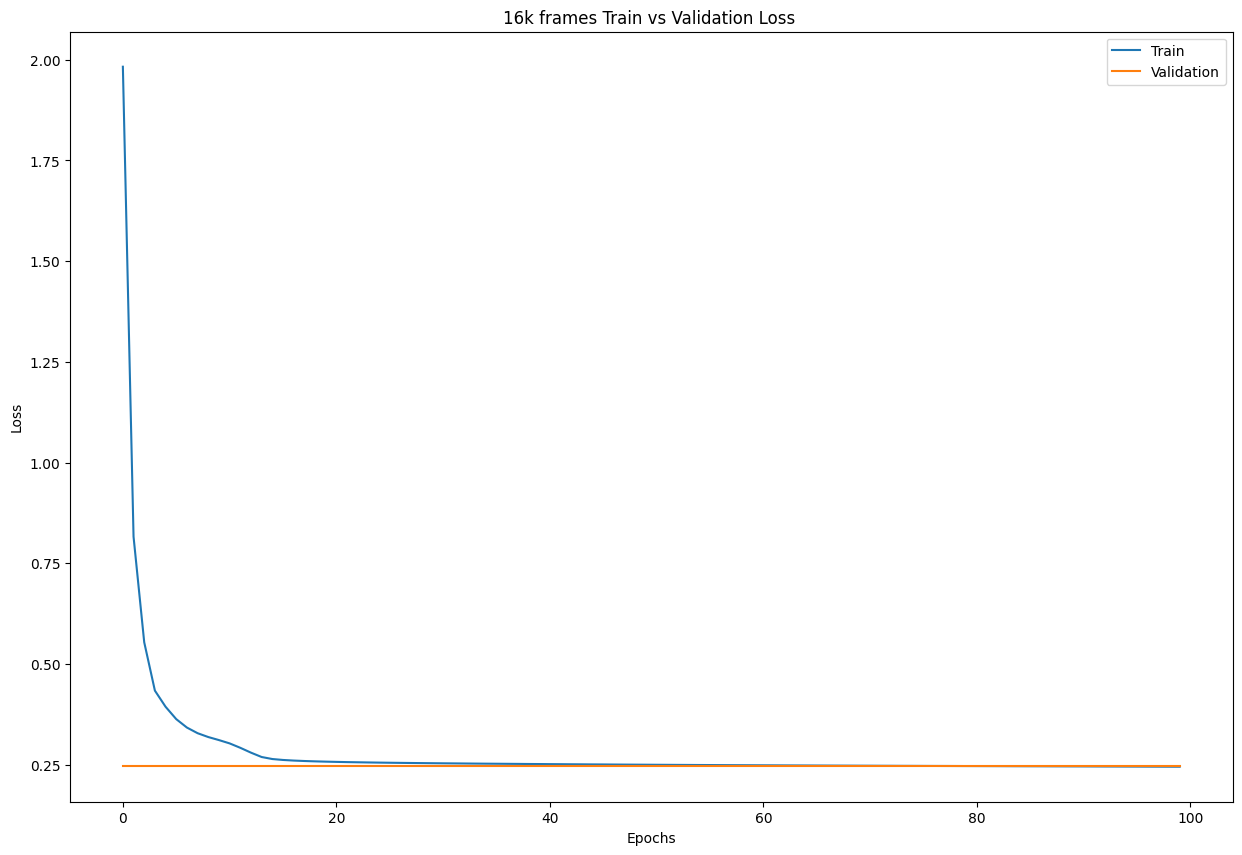

In [22]:
# plotting the losses
# Initial comparision between train and validation losses
plt.figure(figsize=(15,10))
plt.plot(total_train_losses, label='Train')
plt.plot(total_val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('16k frames Train vs Validation Loss ')
plt.savefig('1.png')
plt.show()

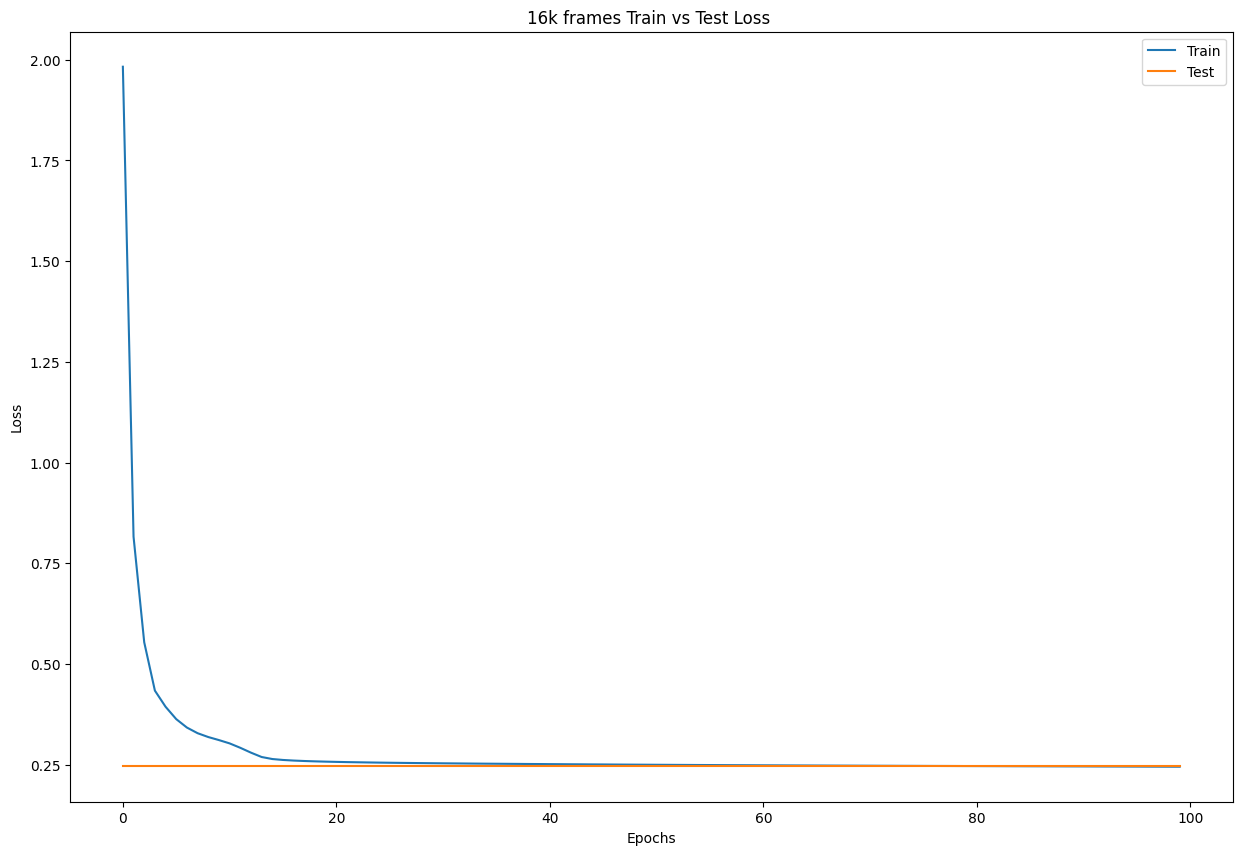

In [23]:
# comparision between train and test losses
plt.figure(figsize=(15,10))
plt.plot(total_train_losses, label='Train')
plt.plot(total_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('16k frames Train vs Test Loss ')
plt.savefig('2.png')
plt.show()


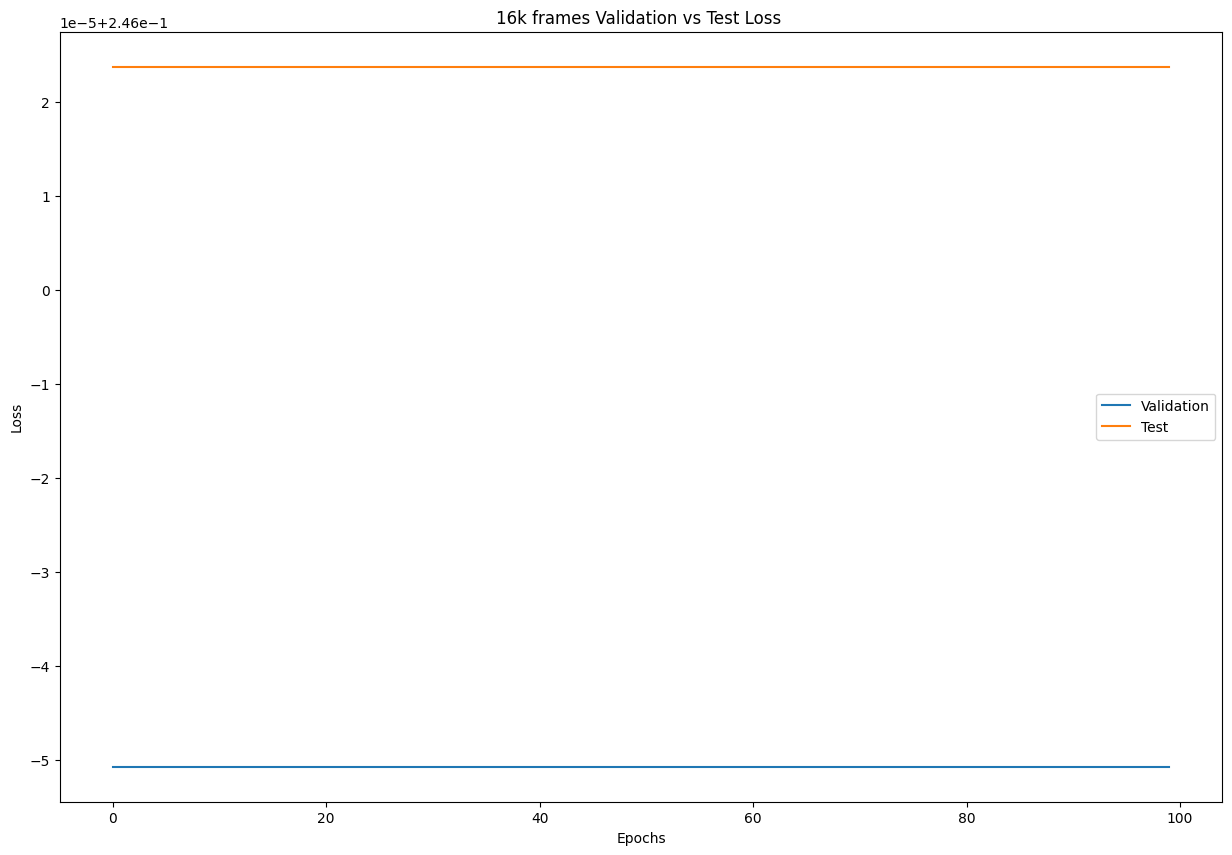

In [24]:
# validation vs test losses
plt.figure(figsize=(15,10))
plt.plot(total_val_losses, label='Validation')
plt.plot(total_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('16k frames Validation vs Test Loss ')
plt.savefig('3.png')
plt.show()


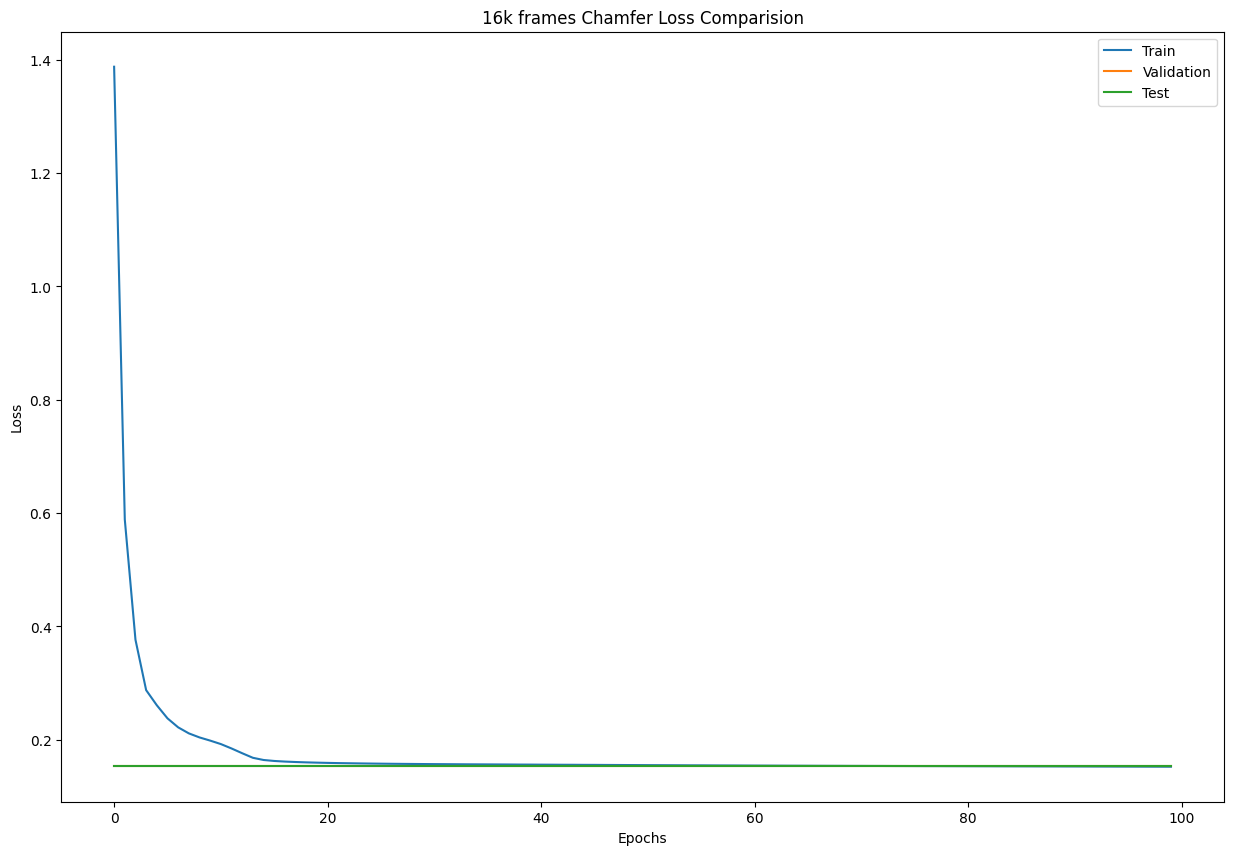

In [25]:
# Chamfer Loss Comparision in all three cases
plt.figure(figsize=(15,10))
plt.plot(closs_train_losses, label='Train')
plt.plot(closs_val_losses, label='Validation')
plt.plot(closs_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('16k frames Chamfer Loss Comparision')
plt.savefig('4.png')
plt.show()


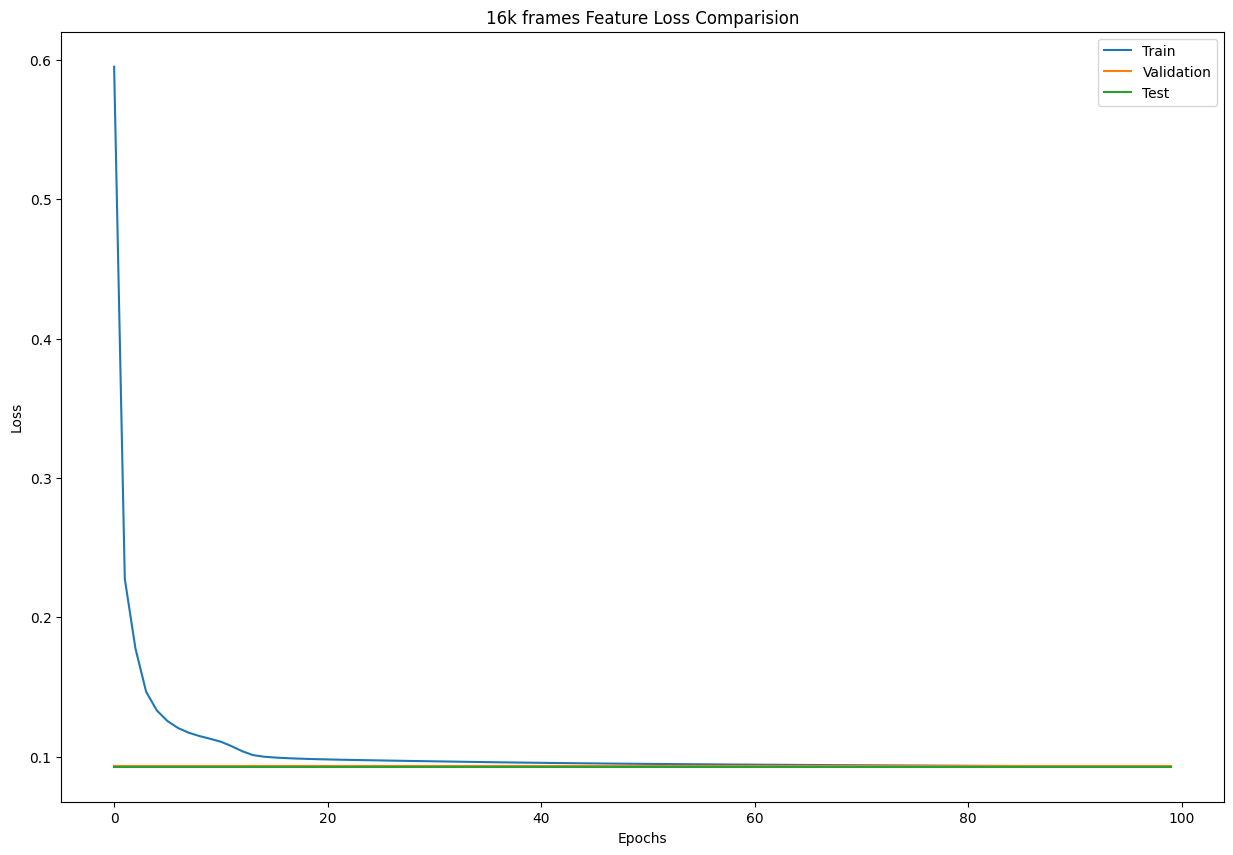

In [26]:
# Feature Loss Comparision in all three cases
plt.figure(figsize=(15,10))
plt.plot(feature_train_losses, label='Train')
plt.plot(feature_val_losses, label='Validation')
plt.plot(feature_test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('16k frames Feature Loss Comparision')
plt.savefig('5.png')
plt.show()
